# An example of loading a model from the model database, and running inference with it

## Load model & set up genome

In [1]:
from pathlib import Path
import numpy as np
%matplotlib inline
import matplotlib
import anndata as ad
import keras
import crested
import pandas as pd

2025-01-14 13:23:48.702938: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-14 13:23:48.741307: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX512_FP16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-14 13:23:51.181611: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
model_path, output_names = crested.get_model('BICCN')
model = keras.models.load_model(model_path)

2025-01-14 13:23:59.663403: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78790 MB memory:  -> device: 0, name: NVIDIA H100 80GB HBM3, pci bus id: 0000:55:00.0, compute capability: 9.0


In [3]:
# Set the genome
genome_dir = Path("../../../../mouse/biccn/")
genome = crested.Genome(genome_dir / "mm10.fa", genome_dir / "mm10.chrom.sizes")
crested.register_genome(genome)

2025-01-14T13:24:00.339598+0100 INFO Genome mm10 registered.


### Make CREsted class
Since there is not anndata object immediately available, we will make an empty object to pass as parameter. (Temporary solution)

In [4]:
adata = ad.AnnData(
    X=np.zeros((len(output_names), 1)),
    obs=pd.DataFrame(
        index=output_names
    ),
    var=pd.DataFrame(
        index=["chr2:20040502-20041072"] #random region
    )
)
adata.obs = pd.DataFrame(index=output_names)
datamodule = crested.tl.data.AnnDataModule(
    adata,
    batch_size=256,  # lower this if you encounter OOM errors
)
evaluator = crested.tl.Crested(data=datamodule)
evaluator.model = model

## Region predictions and contribution scores

In [5]:
chrom = "chr3"  
start = 72535878 - 807  
end = 72536378 + 807
sequence = genome.fetch(chrom, start, end).upper()

prediction = evaluator.predict_sequence(sequence)

I0000 00:00:1736857440.597911  691719 service.cc:145] XLA service 0x7fadc8003200 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1736857440.597942  691719 service.cc:153]   StreamExecutor device (0): NVIDIA H100 80GB HBM3, Compute Capability 9.0
2025-01-14 13:24:00.614535: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-01-14 13:24:00.695107: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


I0000 00:00:1736857441.409604  691719 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [6]:
crested.pl.bar.prediction(prediction, classes=list(adata.obs_names), x_label_rotation=90)

In [7]:
classes_of_interest = [adata.obs_names[np.argmax(prediction)]]
scores, one_hot_encoded_sequences = evaluator.calculate_contribution_scores_sequence(
    sequence, class_names=classes_of_interest
) 

2025-01-14T13:24:01.486087+0100 INFO Calculating contribution scores for 1 class(es) and 1 region(s).


Region: 100%|██████████| 1/1 [00:03<00:00,  3.07s/it]


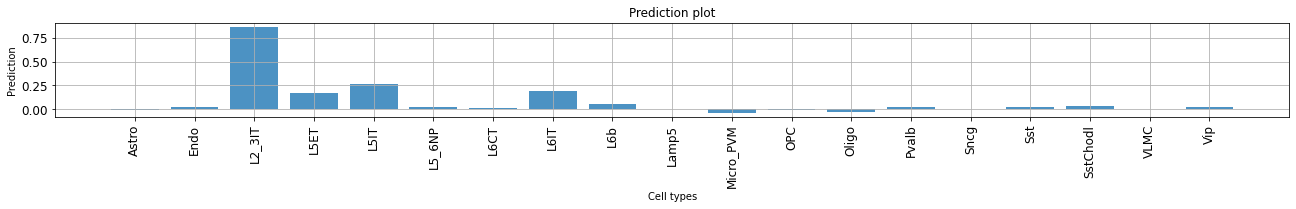

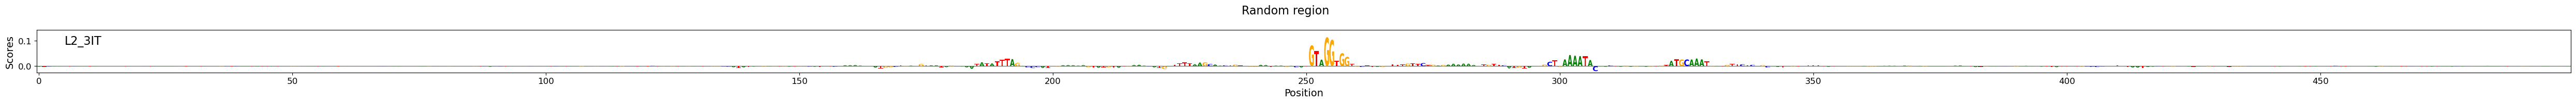

In [8]:
%matplotlib inline
crested.pl.patterns.contribution_scores(
    scores,
    one_hot_encoded_sequences,
    sequence_labels=[''],
    class_labels=classes_of_interest,
    zoom_n_bases=500,
    title="Random region",
)  # zoom in on the center 500bp

### Same region with another model

In [9]:
model_path, output_names = crested.get_model('DeepMouseBrain3')
model2 = keras.models.load_model(model_path)

In [10]:
adata2 = ad.AnnData(
    X=np.zeros((len(output_names), 1)),
    obs=pd.DataFrame(
        index=output_names
    ),
    var=pd.DataFrame(
        index=["chr2:20040502-20041072"] #random region
    )
)
datamodule = crested.tl.data.AnnDataModule(
    adata2,
    batch_size=256,  # lower this if you encounter OOM errors
)
evaluator2 = crested.tl.Crested(data=datamodule)
evaluator2.model = model2

In [11]:
prediction = evaluator2.predict_sequence(sequence)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 989ms/step


/home/VIB.LOCAL/niklas.kempynck/.conda/envs/crested/lib/python3.11/site-packages/crested/pl/_utils.py:95: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


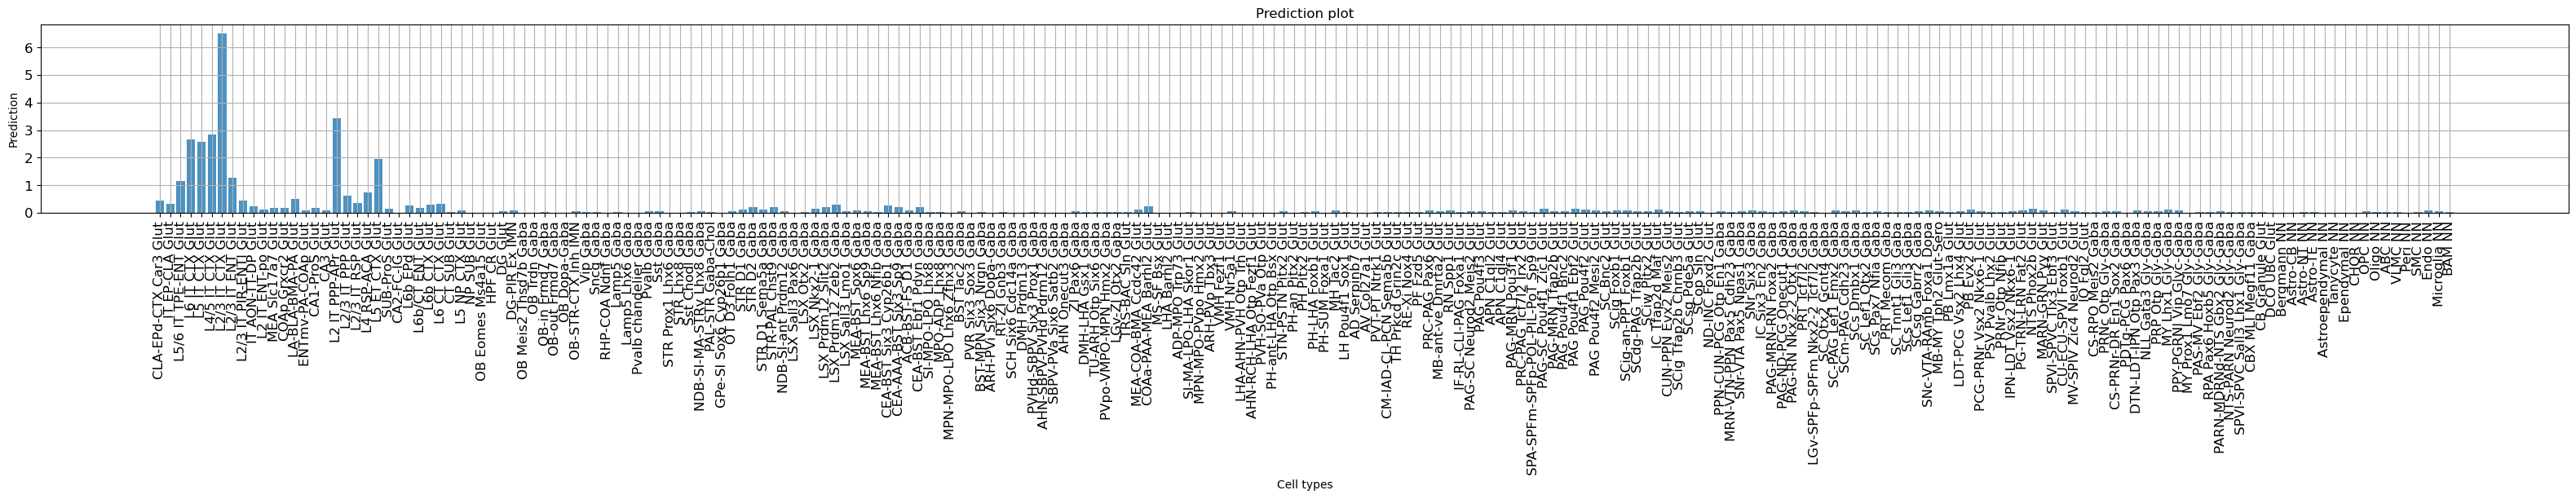

In [12]:
crested.pl.bar.prediction(prediction, classes=list(adata2.obs_names), x_label_rotation=90, width=40)

In [13]:
classes_of_interest = [adata2.obs_names[np.argmax(prediction)]]
scores, one_hot_encoded_sequences = evaluator2.calculate_contribution_scores_sequence(
    sequence, class_names=classes_of_interest
) 

2025-01-14T13:24:08.990983+0100 INFO Calculating contribution scores for 1 class(es) and 1 region(s).


Region: 100%|██████████| 1/1 [00:04<00:00,  4.48s/it]


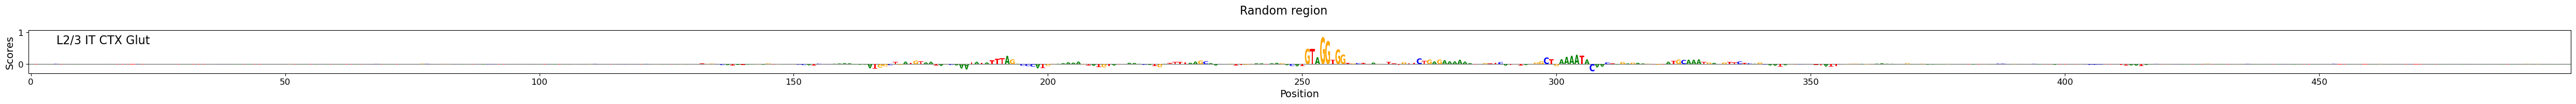

In [14]:
%matplotlib inline
crested.pl.patterns.contribution_scores(
    scores,
    one_hot_encoded_sequences,
    sequence_labels=[''],
    class_labels=classes_of_interest,
    zoom_n_bases=500,
    title="Random region",
)  # zoom in on the center 500bp

## Gene locus predictions

### With BICCN model

In [15]:
chrom = "chr4"
start = 91209533
end = 91374781

scores, coordinates, min_loc, max_loc, tss_position = evaluator.score_gene_locus(
    chr_name=chrom,
    gene_start=start,
    gene_end=end,
    class_name="Sst",
    strand="-",
    upstream=50000,
    downstream=10000,
    step_size=100,
)

In [16]:
# Optional
bigwig = "../../../../mouse/biccn/bigwigs/bws/Sst.bw"
bw_values, midpoints = crested.utils.extract_bigwig_values_per_bp(bigwig, coordinates)

2025-01-14T13:24:20.171645+0100 WARNING extract_bigwig_values_per_bp() is deprecated. Please use crested.utils.read_bigwig_region(bw_file, (chr, start, end)) instead.


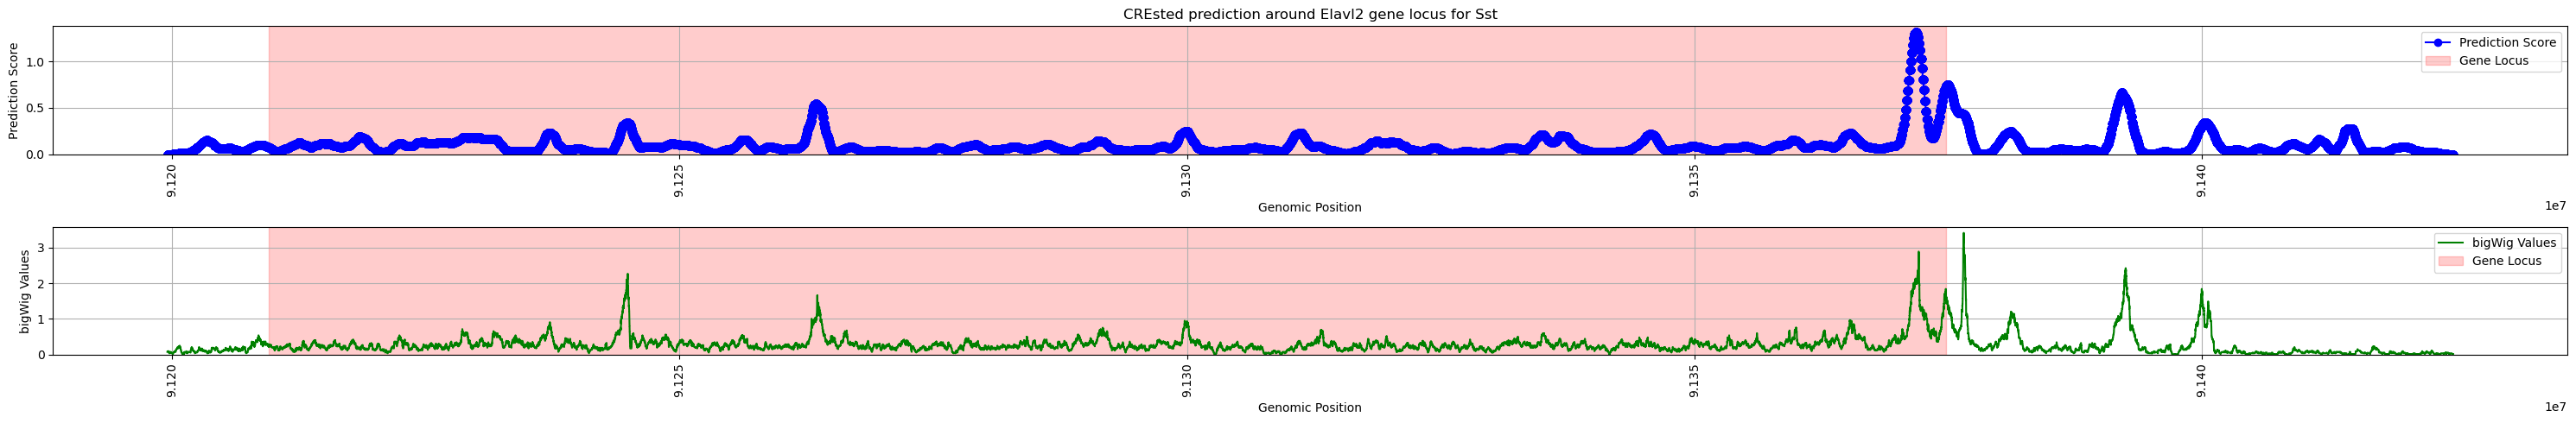

In [17]:
%matplotlib inline
crested.pl.hist.locus_scoring(
    scores,
    (min_loc, max_loc),
    gene_start=start,
    gene_end=end,
    title="CREsted prediction around Elavl2 gene locus for Sst",
    bigwig_values=bw_values,
    bigwig_midpoints=midpoints,
)

### With DeepMouseBrain3

In [18]:
scores, coordinates, min_loc, max_loc, tss_position = evaluator2.score_gene_locus(
    chr_name=chrom,
    gene_start=start,
    gene_end=end,
    class_name="Sst Gaba",
    strand="-",
    upstream=50000,
    downstream=10000,
    step_size=100,
)

I0000 00:00:1736857461.732160  692056 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_369', 184 bytes spill stores, 184 bytes spill loads

I0000 00:00:1736857467.117323  692099 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_369', 208 bytes spill stores, 208 bytes spill loads



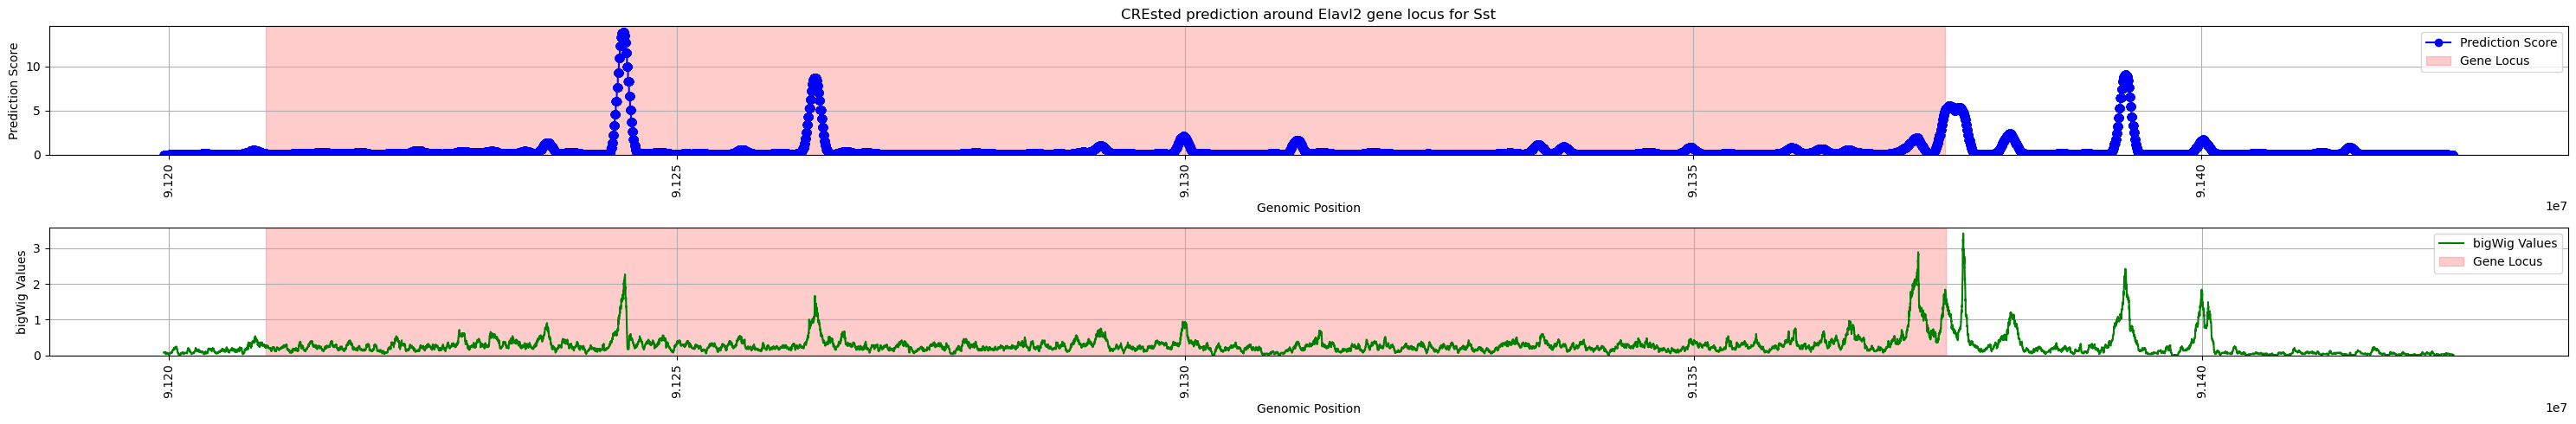

In [19]:
%matplotlib inline
crested.pl.hist.locus_scoring(
    scores,
    (min_loc, max_loc),
    gene_start=start,
    gene_end=end,
    title="CREsted prediction around Elavl2 gene locus for Sst",
    bigwig_values=bw_values,
    bigwig_midpoints=midpoints,
)